In [1]:
import numpy as np
import lbg_forecast.sps as sps
import lbg_forecast.hyperparameters as hyp
import lbg_forecast.population_model as pop
import lbg_forecast.priors as pr
import lbg_forecast.sfh as sfh
import lbg_forecast.lyalpha as ly
import matplotlib.pyplot as plt

In [2]:
nrealisations = 1000  
sps_model = sps.initialise_sps_model(neb_em=True, sfh_type=3, zcont=1, imf_type=2, dust_type=0, igm=True)
hyperparameter_mu_bounds, hyperparameter_sigma_max  = hyp.default_hyperparameter_bounds()
prior_parameters = hyp.sample_prior_parameters(nrealisations, hyperparameter_mu_bounds, hyperparameter_sigma_max)
redshift_mass_prior_parameters = pr.preload_prior_data()

In [3]:
ngalaxies = 50000
sps_parameters = pop.generate_sps_parameters(ngalaxies, prior_parameters[np.random.randint(0, nrealisations),:], redshift_mass_prior_parameters, uniform_redshift_mass=False, uniform_logf=False)

Text(0.5, 0, 'wavelength (angstroms)')

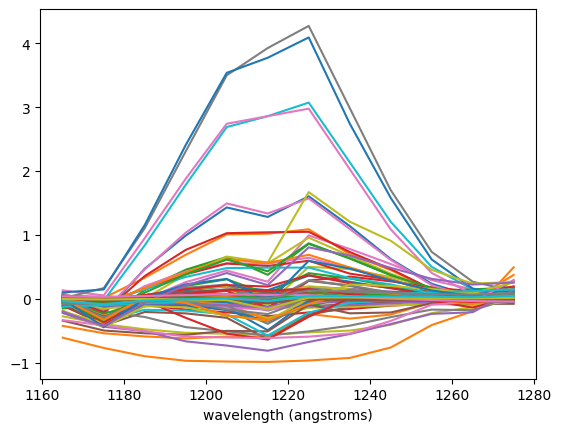

In [4]:
i=0
equiv_widths = []
lyalphas = []
redshifts = []
specs = []
em1s = []
em2s = []
continuums = []

sample = 100

while(i < sample):
    
    sps.update_model(sps_model, sps_parameters[i], z_history=False, agebins=sfh.default_agebins())
    spectrum_data = sps.fsps_get_sed(sps_model)
    wave = spectrum_data[0]
    sed = spectrum_data[1] #sps.redshift_fsps_spectrum(sps_model, spectrum_data)
    redshift = sps_model.params['zred']
    redshifts.append(redshift)

    dlambda = 60
    lyalpha = 1215.16#*(1+redshift)
    lyalphas.append(lyalpha)

    continuum_level = ly.estimate_continuum(wave, sed, lyalpha, dlambda)
    continuums.append(continuum_level)

    indx = ly.find_wave_range(wave, lyalpha, dlambda)
    area = np.trapz(sed[indx] - continuum_level, wave[indx])
    equiv_width = area/continuum_level
    equiv_widths.append(equiv_width)
    specs.append((wave, sed))
    plt.plot(wave[indx], ((sed[indx]-continuum_level)/area)*equiv_width)

    i+=1

equiv_widths = np.array(equiv_widths)
continuums = np.array(continuums)
lyalphas = np.array(lyalphas)
plt.xlabel("wavelength (angstroms)")

no: 11


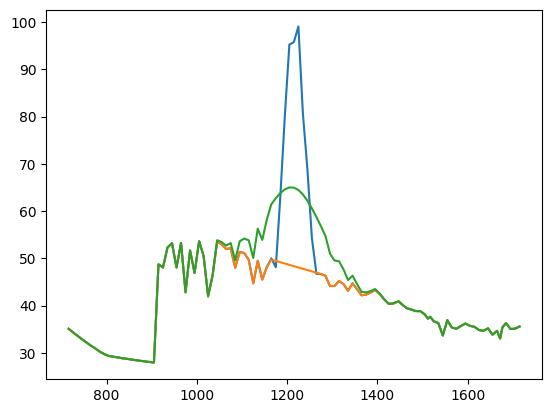

In [83]:
j = np.random.randint(0, sample)
wave, sed = specs[j]
redshift = redshifts[j]
mod_sed = ly.modify_peak(wave, sed, 60, 60, 0, 1.0, diagnostics=True)

print("no:", j)


EW:  54.54660348501798


Text(0.5, 0, 'wavelength (angstroms)')

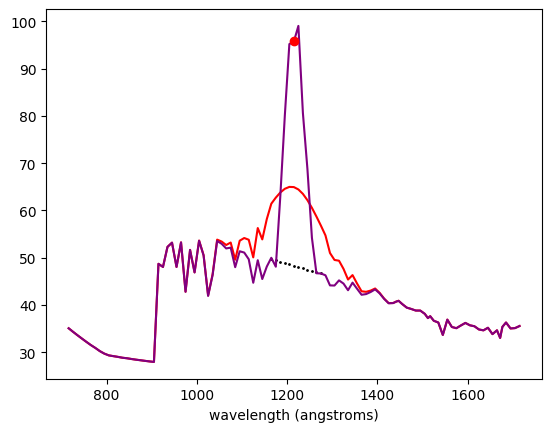

In [89]:
j = np.random.randint(0, sample)
wave, sed = specs[j]
lyalpha = lyalphas[j]
redshift = redshifts[j]
print("EW: ", equiv_widths[j])

plot_lambda = 500

indx = ly.find_wave_range(wave, lyalpha, dlambda)
continuum_level = ly.estimate_continuum(wave, sed, lyalpha, dlambda)
continuum_points = ly.lin_interp(wave[indx], sed[indx], lyalpha, dlambda)

modified_sed = ly.modify_peak(wave, sed, 60, 60, 0, 1, diagnostics=False)

indx_p = ly.find_wave_range(wave, lyalpha, plot_lambda)
plt.plot(wave[indx_p], modified_sed[indx_p], c="red")
plt.plot(wave[indx_p], sed[indx_p], c="purple")
plt.plot(lyalpha,np.interp(lyalpha, wave, sed),'ro')
plt.scatter(wave[indx],continuum_points, s=1, c='k') 

#plt.yscale('log')
plt.xlabel("wavelength (angstroms)")

Text(0.5, 0, 'EW (angstroms)')

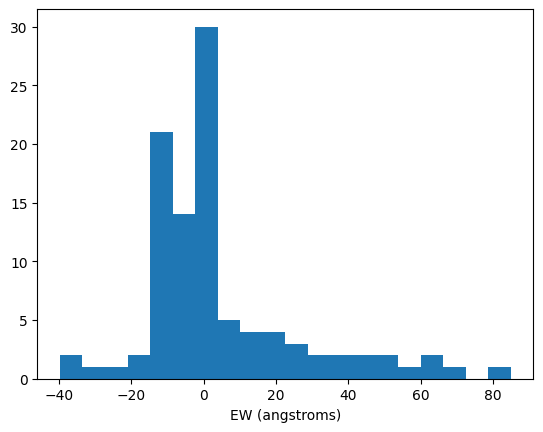

In [ ]:
plt.hist(equiv_widths, bins=20)
plt.xlabel("EW (angstroms)")

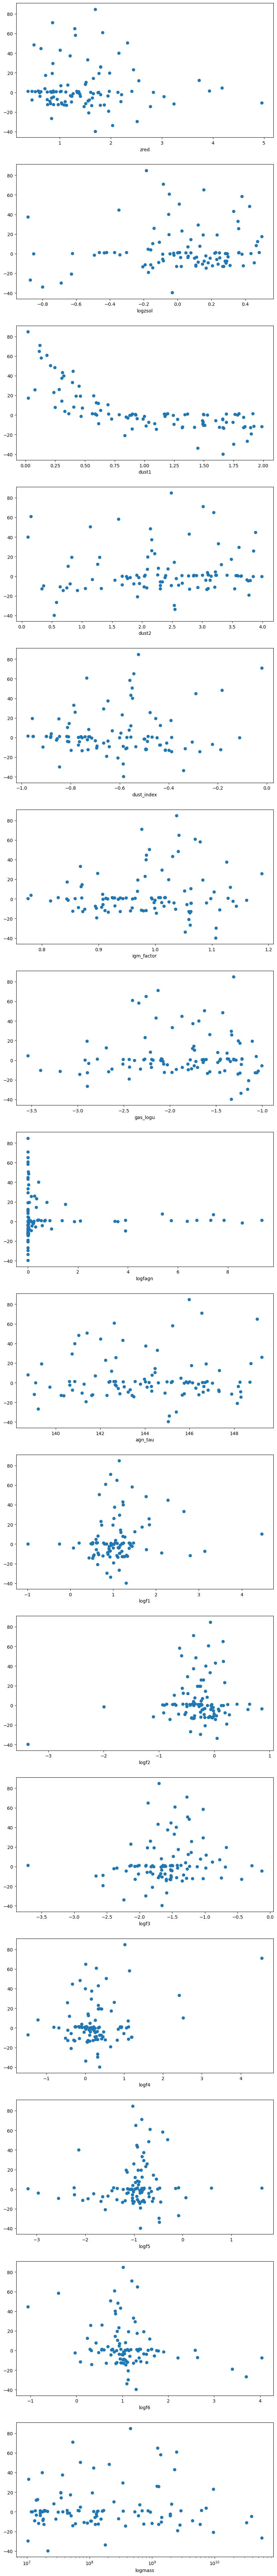

In [ ]:
sps_parameter_names = pop.sps_parameter_names()
fig1, axes = plt.subplots(len(sps_parameter_names), 1, figsize=(10,100), sharex=False, sharey=False)

for i in range(0, len(sps_parameter_names)):
    axes[i].scatter(sps_parameters[:sample][:, i], equiv_widths)
    axes[i].set_xlabel(sps_parameter_names[i])
    if(sps_parameter_names[i] == 'logmass'):
        axes[i].set_xscale('log')